<a href="https://colab.research.google.com/github/quent1fvr/Infection_pulmonaire/blob/main/Infection_pulmonaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I - Importation des données

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import tensorflow as tf
import keras
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/UV PROJET P6/COVID_dataset.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

print(len(os.listdir('/tmp/COVID_crop/malade')))
print(len(os.listdir('/tmp/COVID_crop/normal')))
path ='/tmp/COVID_crop'

1544
1078


# II - Etude de la distribution des données "brutes"

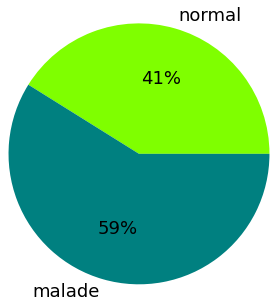

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

path_malade = "/tmp/COVID_crop/malade"
path_normal = "/tmp/COVID_crop/normal"

x = np.array([len(os.listdir(path_normal)), len(os.listdir(path_malade))])
labels = ['normal', 'malade']
colors = {'normal': 'chartreuse','malade': 'teal' }
plt.pie(x, labels=labels, autopct='%.0f%%', radius=1.5, colors=[colors[key] for key in labels], textprops={'fontsize': 18})
plt.show()

[18, 21, 21, 22, 22, 22, 24, 24, 24, 25, 25, 25, 25, 25, 25, 26, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31, 31, 32, 32, 32, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 43, 43, 44, 44, 44, 44, 45, 45, 46, 48, 54, 54, 55, 55, 55, 55, 55, 56, 56, 56, 57, 57, 57, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 66, 66,

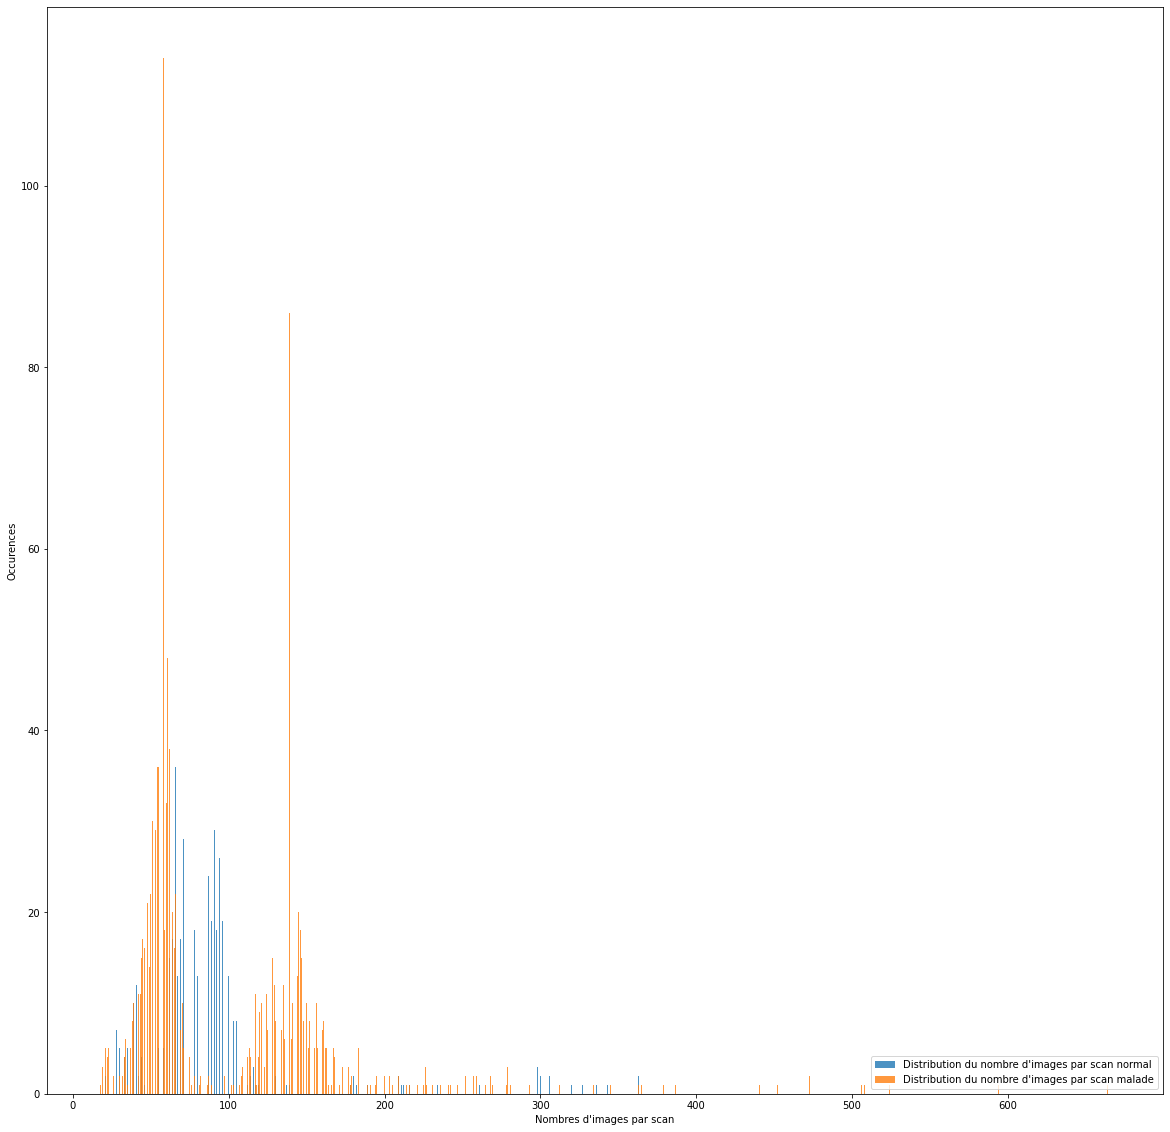

In [9]:
#--------------------------------- Visualisation des données --------------------------------- 

plt.figure(figsize=(20, 20))

tab_normal = []
tab_malade = []

dir_normal = '/tmp/COVID_crop/normal'
dir_malade = '/tmp/COVID_crop/malade'

for base in os.walk(dir_normal):
    #print('folder "', base[0], '" containing ', len(base[2]), ' files')
    tab_normal.append(len(base[2]))
tab_normal.pop(0)
tab_normal.sort()
print(tab_normal)

for base in os.walk(dir_malade):
    #print('folder "', base[0], '" containing ', len(base[2]), ' files')
    tab_malade.append(len(base[2]))
tab_malade.pop(0)
tab_malade.sort()
print(tab_malade)

x0 = tab_normal
x1 = tab_malade

bins = max(len(x0), len(x1))

plt.hist(x0, bins, alpha=0.8, label="Distribution du nombre d'images par scan normal")
plt.hist(x1, bins, alpha=0.8, label="Distribution du nombre d'images par scan malade")
plt.legend(loc='lower right')
plt.xlabel("Nombres d'images par scan")
plt.ylabel("Occurences")
plt.show()

In [10]:
x0 = np.array(x0)
x1 = np.array(x1)
x0_mean = np.mean(x0)
x1_mean = np.mean(x1)
avg = (59*x0_mean + 41*x1_mean)/100

print("x0_mean", x0_mean)
print("x1_mean", x1_mean)
print("avg", avg)

x0_mean 88.82745825602969
x1_mean 101.08225388601036
avg 93.85192446432177


# III - Padding des données

### 1. On élimine les scans contenant moins de 40 et plus de 100 images


In [11]:
import shutil
num_skipped = 0
for folder_name in ("normal", "malade"):
    folder_path = os.path.join("/tmp/COVID_crop", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        if len(os.listdir(fpath)) > 100 or len(os.listdir(fpath)) < 40:
            num_skipped += 1
            shutil.rmtree(fpath)

print("Deleted %d scans" % num_skipped)

Deleted 1016 scans


[40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 43, 43, 44, 44, 44, 44, 45, 45, 46, 48, 54, 54, 55, 55, 55, 55, 55, 56, 56, 56, 57, 57, 57, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,

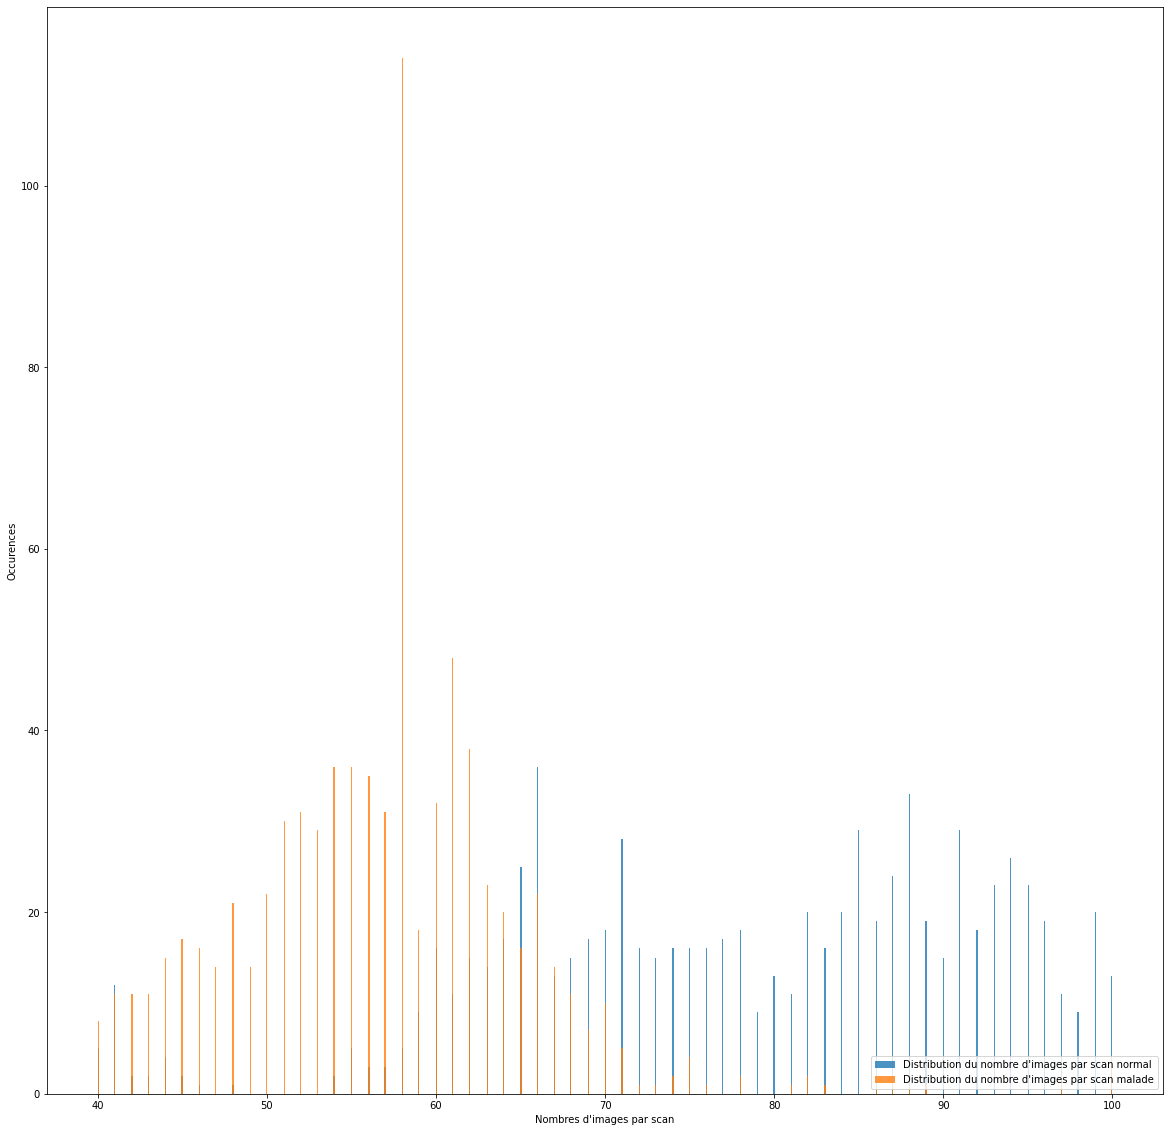

In [12]:
#--------------------------------- Visualisation des données --------------------------------- 

plt.figure(figsize=(20, 20))

tab_normal = []
tab_malade = []

dir_normal = '/tmp/COVID_crop/normal'
dir_malade = '/tmp/COVID_crop/malade'

for base in os.walk(dir_normal):
    #print('folder "', base[0], '" containing ', len(base[2]), ' files')
    tab_normal.append(len(base[2]))
tab_normal.pop(0)
tab_normal.sort()
print(tab_normal)

for base in os.walk(dir_malade):
    #print('folder "', base[0], '" containing ', len(base[2]), ' files')
    tab_malade.append(len(base[2]))
tab_malade.pop(0)
tab_malade.sort()
print(tab_malade)

x0 = tab_normal
x1 = tab_malade

bins = max(len(x0), len(x1))

plt.hist(x0, bins, alpha=0.8, label="Distribution du nombre d'images par scan normal")
plt.hist(x1, bins, alpha=0.8, label="Distribution du nombre d'images par scan malade")
plt.legend(loc='lower right')
plt.xlabel("Nombres d'images par scan")
plt.ylabel("Occurences")
plt.show()

In [13]:
x0 = np.array(x0)
x1 = np.array(x1)
x0_mean = np.mean(x0)
x1_mean = np.mean(x1)
avg = (59*x0_mean + 41*x1_mean)/100

print("x0_mean", x0_mean)
print("x1_mean", x1_mean)
print("avg", avg)

x0_mean 78.26412776412776
x1_mean 57.015151515151516
avg 69.5520475020475


### 2.1. On comble les scans contenant moins de 70 images par des images noires 

In [ ]:
num_skipped = 0
from PIL import Image
for folder_name in ("normal", "malade"):
    folder_path = os.path.join("/tmp/COVID_crop", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        if len(os.listdir(fpath))<70:
          for i in range (70 - len(os.listdir(fpath))) : 
            new_im = Image.new('RGB', (128,128), (0,0,0))
            new_im.save(fpath+"/Dark_image"+str(i), "PNG")

[70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,

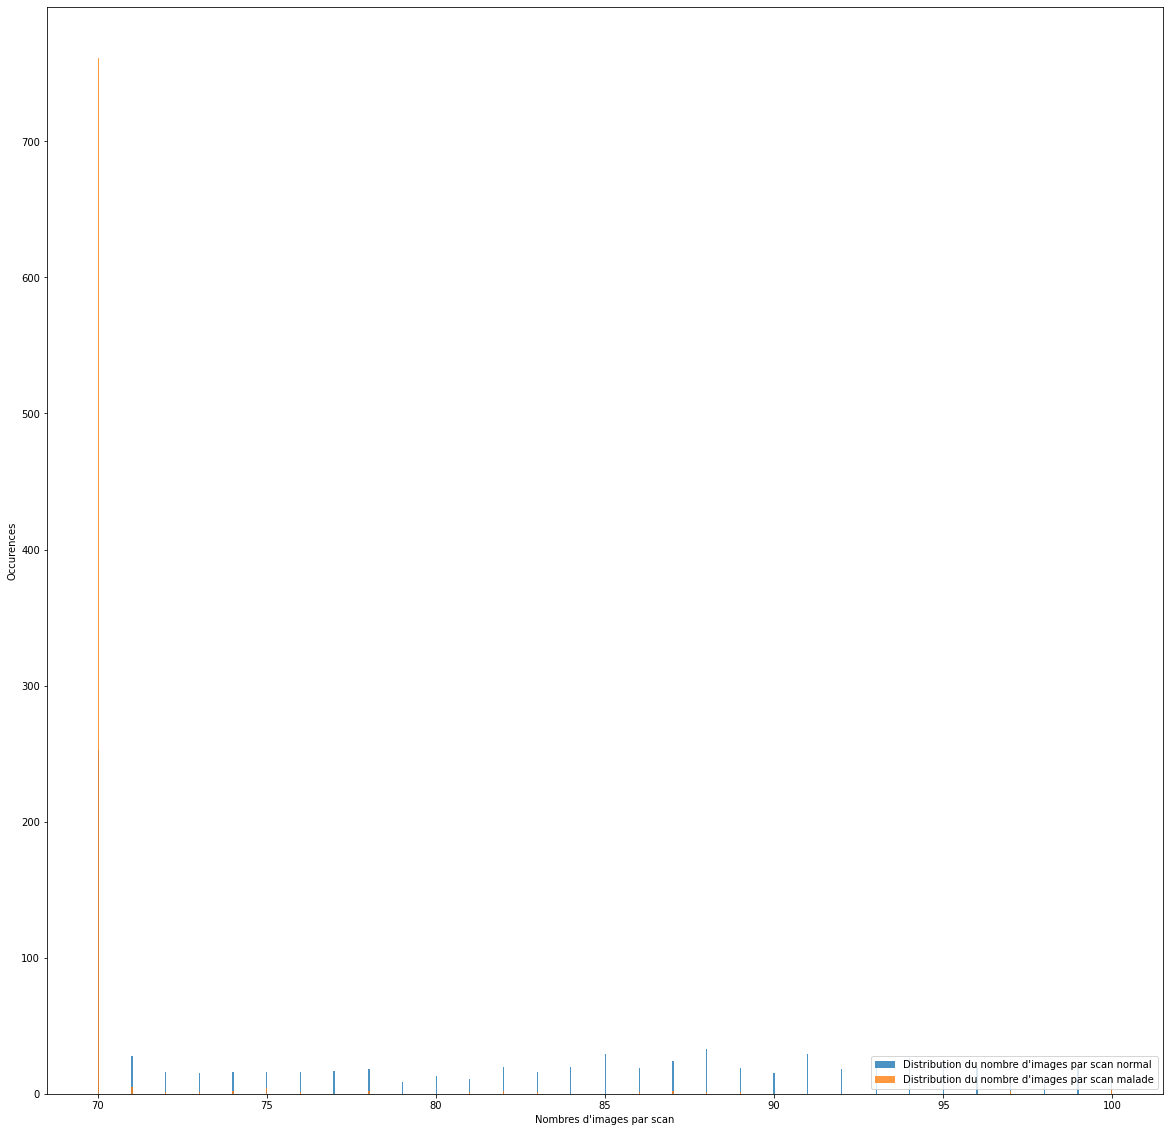

In [ ]:
#--------------------------------- Visualisation des données --------------------------------- 

plt.figure(figsize=(20, 20))

tab_normal = []
tab_malade = []

dir_normal = '/tmp/COVID_crop/normal'
dir_malade = '/tmp/COVID_crop/malade'

for base in os.walk(dir_normal):
    #print('folder "', base[0], '" containing ', len(base[2]), ' files')
    tab_normal.append(len(base[2]))
tab_normal.pop(0)
tab_normal.sort()
print(tab_normal)

for base in os.walk(dir_malade):
    #print('folder "', base[0], '" containing ', len(base[2]), ' files')
    tab_malade.append(len(base[2]))
tab_malade.pop(0)
tab_malade.sort()
print(tab_malade)

x0 = tab_normal
x1 = tab_malade

bins = max(len(x0), len(x1))

plt.hist(x0, bins, alpha=0.8, label="Distribution du nombre d'images par scan normal")
plt.hist(x1, bins, alpha=0.8, label="Distribution du nombre d'images par scan malade")
plt.legend(loc='lower right')
plt.xlabel("Nombres d'images par scan")
plt.ylabel("Occurences")
plt.show()

### 2.2. On comble les scans contenant moins de 70 par des copies d'images "intéressantes"


### 3.1. On élimine aléatoirement des images dans les scans contenant plus de 70 images

In [ ]:
import shutil
for folder_name in ("normal", "malade"):
    folder_path = os.path.join("/tmp/COVID_crop", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        if len(os.listdir(fpath))>70:
            for i in range(len(os.listdir(fpath))-70):
                delete_path = fpath+"/00"+str(np.random.randint(10,len(os.listdir(fpath))))+".png"
                while os.path.exists(delete_path):
                    os.remove(delete_path)

[70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,

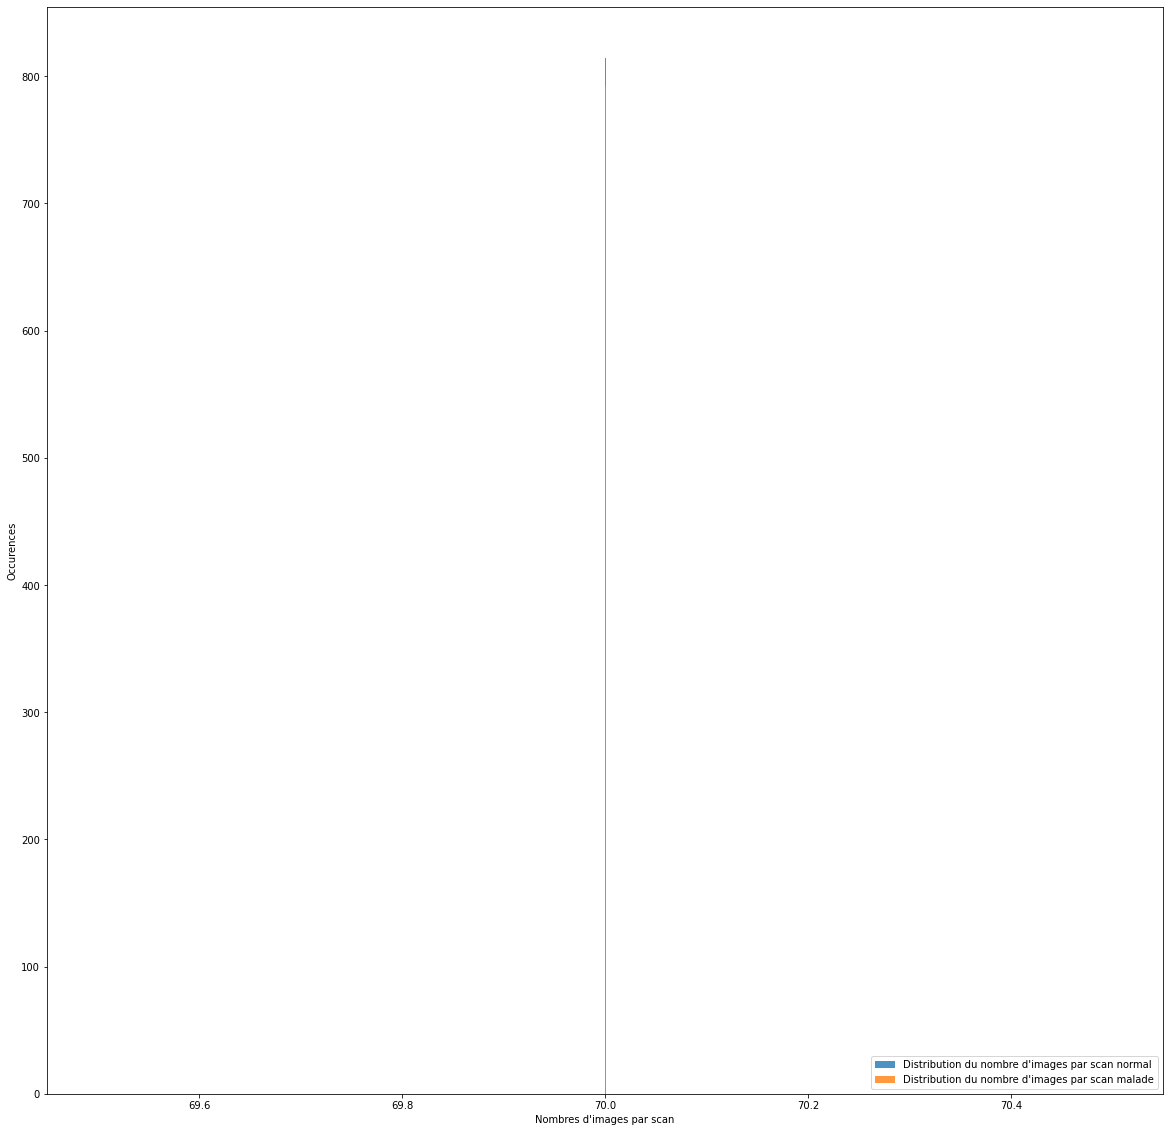

In [ ]:
#--------------------------------- Visualisation des données --------------------------------- 

plt.figure(figsize=(20, 20))

tab_normal = []
tab_malade = []

dir_normal = '/tmp/COVID_crop/normal'
dir_malade = '/tmp/COVID_crop/malade'

for base in os.walk(dir_normal):
    #print('folder "', base[0], '" containing ', len(base[2]), ' files')
    tab_normal.append(len(base[2]))
tab_normal.pop(0)
tab_normal.sort()
print(tab_normal)

for base in os.walk(dir_malade):
    #print('folder "', base[0], '" containing ', len(base[2]), ' files')
    tab_malade.append(len(base[2]))
tab_malade.pop(0)
tab_malade.sort()
print(tab_malade)

x0 = tab_normal
x1 = tab_malade

bins = max(len(x0), len(x1))

plt.hist(x0, bins, alpha=0.8, label="Distribution du nombre d'images par scan normal")
plt.hist(x1, bins, alpha=0.8, label="Distribution du nombre d'images par scan malade")
plt.legend(loc='lower right')
plt.xlabel("Nombres d'images par scan")
plt.ylabel("Occurences")
plt.show()

### 3.2. On élimine par MSE & SSIM des images dans les scans contenant plus de 70 images

#### 3.2.1. Test avec deux images random

In [35]:
from skimage.metrics import structural_similarity as compare_ssim
import argparse
import imutils
import cv2

location_image1 = "/tmp/COVID_crop/normal/1/0015.png"
location_image2 = "/tmp/COVID_crop/normal/1/0020.png"

# load the two input images
imageA = cv2.imread(location_image1)
imageB = cv2.imread(location_image2)

# compute the Structural Similarity Index (SSIM) between the two
# images, ensuring that the difference image is returned
(score, diff) = compare_ssim(imageA, imageB, full=True, multichannel=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(score))

SSIM: 0.6850154484352456


The ***score*** represents the structural similarity index between the two input images. This value can fall into the range [-1, 1] with a value of one being a “perfect match”.

The ***diff*** image contains the actual image differences between the two input images that we wish to visualize. The difference image is currently represented as a floating point data type in the range [0, 1] so we first convert the array to 8-bit unsigned integers in the range [0, 255] (Line 26) before we can further process it using OpenCV.

Score of similarity =  0.6850154484352456 /1

Image 1 :



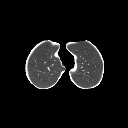


Image 2 :



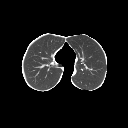


Différence :



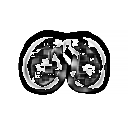

In [39]:
from google.colab.patches import cv2_imshow
# show the output images
print("Score of similarity = ", score, "/1")
print("\nImage 1 :\n")
cv2_imshow(imageA)
print("\nImage 2 :\n")
cv2_imshow(imageB)
print("\nDifférence :\n")
cv2_imshow(diff)

#### 3.2.2. Test avec une banque d'images

In [ ]:
from skimage.metrics import structural_similarity as compare_ssim
import argparse
import imutils
import cv2

location_image1 = "/tmp/COVID_crop/normal/1/0015.png"
location_image2 = "/tmp/COVID_crop/normal/1/0020.png"

# load the two input images
imageA = cv2.imread(location_image1)
imageB = cv2.imread(location_image2)

# compute the Structural Similarity Index (SSIM) between the two
# images, ensuring that the difference image is returned
(score, diff) = compare_ssim(imageA, imageB, full=True, multichannel=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(score))

In [ ]:
from google.colab.patches import cv2_imshow
# show the output images
print("Score of similarity = ", score, "/1")
print("\nImage 1 :\n")
cv2_imshow(imageA)
print("\nImage 2 :\n")
cv2_imshow(imageB)
print("\nDifférence :\n")
cv2_imshow(diff)

# IV - Etude de la distribution des données "normalisées"

# V - Phase d'entrainement du modèle

